In [2]:

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.metrics import classification_report
from transformers import DistilBertTokenizer, TFDistilBertForSequenceClassification, AutoTokenizer
import tensorflow as tf
from sklearn.multioutput import MultiOutputClassifier
from transformers import AutoModelForSequenceClassification, Trainer, TrainingArguments
from torch.utils.data import Dataset
import torch


In [3]:

df = pd.read_csv('./data/final_hateXplain.csv')
print(len(df))

df =df.drop(['Miscellaneous', 'label'], axis=1)


# Check for missing values
print(df.isnull().sum())

# Basic exploration of the dataset
print(df['comment'].value_counts())
print(df.head())


20109
comment               0
Race                  0
Religion              0
Gender                0
Sexual Orientation    0
dtype: int64
0 u0 lmao wow fuck you too 😂 😂                                                                                                                                                                                                                                                                 1
nigger jokes are more played out than groyper avis keep using it it has no effect meanwhile all you do is whine and bitch way to save the west bitching on gab my dude                                                                                                                         1
nigger nigger chicken dinner                                                                                                                                                                                                                                                               

In [4]:

race_mapping = {
    'No_race': 0,
    'African': 1,
    'Arab': 1,
    'Asian': 1,
    'Caucasian': 1,
    'Hispanic': 1,
    'Indian': 1,
    'Indigenous': 1
}
religion_mapping = {
    'Nonreligious': 0,
    'Buddhism': 1,
    'Christian': 1,
    'Hindu': 1,
    'Islam': 1,
    'Jewish': 1
}
gender_mapping = {
    'No_gender': 0,
    'Men': 1,
    'Women': 1
}
sexual_orientation_mapping = {
    'No_orientation': 0,
    'Asexual': 1,
    'Bisexual': 1,
    'Heterosexual': 1,
    'Homosexual': 1
}
df['Race'] = df['Race'].map(race_mapping)
df['Religion'] = df['Religion'].map(religion_mapping)
df['Gender'] = df['Gender'].map(gender_mapping)
df['Sexual Orientation'] = df['Sexual Orientation'].map(sexual_orientation_mapping)



category_columns = ['Race','Religion','Gender','Sexual Orientation']


X_train, X_test, y_train, y_test = train_test_split(df['comment'], df[category_columns], test_size=0.2, random_state=42)


tfidf_vectorizer = TfidfVectorizer(max_features=5000)  # Limiting to 5000 features for performance
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)



In [6]:

from sklearn.metrics import accuracy_score


nb_model_mn = MultinomialNB()
multi_output_nb = MultiOutputClassifier(nb_model_mn)
multi_output_nb.fit(X_train_tfidf, y_train)


nb_predictions_mn = multi_output_nb.predict(X_test_tfidf)


y_test_flat = np.array(y_test).reshape(-1)
nb_predictions_flat = np.array(nb_predictions_mn).reshape(-1)

    
print("Accuracy:", accuracy_score(y_test, nb_predictions_mn))
print(classification_report(y_test, nb_predictions_mn))

Accuracy: 0.4510193933366484
              precision    recall  f1-score   support

           0       0.89      0.31      0.45      1346
           1       0.83      0.24      0.37       948
           2       0.69      0.03      0.05       762
           3       0.83      0.03      0.06       495

   micro avg       0.86      0.19      0.31      3551
   macro avg       0.81      0.15      0.23      3551
weighted avg       0.82      0.19      0.29      3551
 samples avg       0.16      0.13      0.14      3551



c:\Python310\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Python310\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Python310\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in samples with no true nor predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [7]:

svm_model = SVC(kernel='linear')  
multi_class_svm = MultiOutputClassifier(svm_model)
multi_class_svm.fit(X_train_tfidf, y_train)


svm_predictions = multi_class_svm.predict(X_test_tfidf)


from sklearn.metrics import accuracy_score, classification_report

print("Accuracy:", accuracy_score(y_test, svm_predictions))
print(classification_report(y_test, svm_predictions))



Accuracy: 0.6103928393833914
              precision    recall  f1-score   support

           0       0.86      0.59      0.70      1346
           1       0.85      0.77      0.81       948
           2       0.68      0.26      0.38       762
           3       0.80      0.68      0.74       495

   micro avg       0.83      0.58      0.68      3551
   macro avg       0.80      0.58      0.65      3551
weighted avg       0.81      0.58      0.66      3551
 samples avg       0.45      0.40      0.41      3551



c:\Python310\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Python310\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Python310\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in samples with no true nor predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [5]:


train_df, test_df = train_test_split(df, test_size=0.1)
print(f"Number of rows in training set: {len(train_df)}")
print(f"Number of rows in test set: {len(test_df)}")


not_chosen_columns = ['comment']
label_columns = [col for col in df.columns if col not in not_chosen_columns]

labels_list_train = train_df[label_columns].values.tolist()
labels_list_test = test_df[label_columns].values.tolist()
labels_list_train = [[float(label) for label in labels] for labels in labels_list_train]
labels_list_test = [[float(label) for label in labels] for labels in labels_list_test]


Number of rows in training set: 18098
Number of rows in test set: 2011


In [6]:
tokenizer = AutoTokenizer.from_pretrained('distilbert-base-uncased')

train_encodings = tokenizer(train_df['comment'].tolist(), padding="max_length", truncation=True, max_length=128)
eval_encodings = tokenizer(test_df['comment'].tolist(), padding="max_length", truncation=True, max_length=128)


In [7]:
class TextClassifierDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item["labels"] = torch.tensor(self.labels[idx])
        return item


train_dataset = TextClassifierDataset(train_encodings, labels_list_train)
eval_dataset = TextClassifierDataset(eval_encodings, labels_list_test)


In [8]:
model = AutoModelForSequenceClassification.from_pretrained(
    "distilbert-base-uncased",
    problem_type="multi_label_classification",
    num_labels=len(label_columns)
)


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


# Train new model

In [18]:

training_arguments = TrainingArguments(
    output_dir="./results",
    evaluation_strategy="epoch",
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=1,
    logging_dir="./logs",
    logging_steps=10,
)

trainer = Trainer(
    model=model,
    args=training_arguments,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
)

trainer.train()


c:\Python310\lib\site-packages\transformers\training_args.py:1545: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


  0%|          | 0/2263 [00:00<?, ?it/s]

{'loss': 0.6231, 'grad_norm': 0.8568973541259766, 'learning_rate': 4.9779054352629255e-05, 'epoch': 0.0}
{'loss': 0.5255, 'grad_norm': 1.0974711179733276, 'learning_rate': 4.955810870525851e-05, 'epoch': 0.01}
{'loss': 0.4949, 'grad_norm': 0.745474636554718, 'learning_rate': 4.933716305788776e-05, 'epoch': 0.01}
{'loss': 0.5078, 'grad_norm': 0.9734501838684082, 'learning_rate': 4.9116217410517014e-05, 'epoch': 0.02}
{'loss': 0.4396, 'grad_norm': 0.9453778862953186, 'learning_rate': 4.889527176314627e-05, 'epoch': 0.02}
{'loss': 0.4836, 'grad_norm': 1.2430545091629028, 'learning_rate': 4.867432611577552e-05, 'epoch': 0.03}
{'loss': 0.4432, 'grad_norm': 1.6520345211029053, 'learning_rate': 4.845338046840477e-05, 'epoch': 0.03}
{'loss': 0.4248, 'grad_norm': 2.2399539947509766, 'learning_rate': 4.8232434821034025e-05, 'epoch': 0.04}
{'loss': 0.4191, 'grad_norm': 3.4501235485076904, 'learning_rate': 4.8011489173663285e-05, 'epoch': 0.04}
{'loss': 0.3535, 'grad_norm': 0.9586362838745117, 'le

  0%|          | 0/252 [00:00<?, ?it/s]

{'eval_loss': 0.2685298025608063, 'eval_runtime': 180.2259, 'eval_samples_per_second': 11.158, 'eval_steps_per_second': 1.398, 'epoch': 1.0}
{'train_runtime': 5795.7234, 'train_samples_per_second': 3.123, 'train_steps_per_second': 0.39, 'train_loss': 0.2912541965810377, 'epoch': 1.0}


TrainOutput(global_step=2263, training_loss=0.2912541965810377, metrics={'train_runtime': 5795.7234, 'train_samples_per_second': 3.123, 'train_steps_per_second': 0.39, 'total_flos': 599370122287104.0, 'train_loss': 0.2912541965810377, 'epoch': 1.0})

# Load old model from checkpoints


In [10]:
training_arguments = TrainingArguments(
    output_dir="./results",
    evaluation_strategy="epoch",
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=1,
    logging_dir="./logs",
    logging_steps=10,
)

trainer = Trainer(
    model=model,
    args=training_arguments,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
)

checkpoint = "./results/checkpoint-2263"

trainer.train(resume_from_checkpoint=checkpoint)

c:\Python310\lib\site-packages\transformers\training_args.py:1545: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
c:\Python310\lib\site-packages\transformers\trainer.py:3262: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for a

  0%|          | 0/2263 [00:00<?, ?it/s]

{'train_runtime': 0.0184, 'train_samples_per_second': 984635.619, 'train_steps_per_second': 123120.257, 'train_loss': 0.0, 'epoch': 1.0}


TrainOutput(global_step=2263, training_loss=0.0, metrics={'train_runtime': 0.0184, 'train_samples_per_second': 984635.619, 'train_steps_per_second': 123120.257, 'total_flos': 599370122287104.0, 'train_loss': 0.0, 'epoch': 1.0})

In [12]:
from torch.utils.data import DataLoader, TensorDataset

batch_size = 16 
sub_texts = test_df['comment'].tolist()
sub_encodings = tokenizer(sub_texts, padding="max_length", truncation=True, return_tensors="pt")
dataset = TensorDataset(sub_encodings['input_ids'], sub_encodings['attention_mask'])

dataloader = DataLoader(dataset, batch_size=batch_size)
model.eval()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

all_probabilities = []
with torch.no_grad():
    for batch in dataloader:
        batch = {key: val.to(device) for key, val in zip(['input_ids', 'attention_mask'], batch)}
        outputs = model(**batch)
        logits = outputs.logits
        probabilities = torch.sigmoid(logits).cpu().numpy()
        all_probabilities.extend(probabilities)

# Convert results to a single array if needed
all_probabilities = np.array(all_probabilities)


In [22]:
import numpy as np

new_threshold = 0.75 
predictions = (all_probabilities >= new_threshold).astype(int)
print(len(predictions), len(all_probabilities))


from sklearn.metrics import accuracy_score, precision_recall_fscore_support
labels = test_df[label_columns]
print(labels.head())


# Calculate metrics
accuracy = accuracy_score(labels, predictions)
precision, recall, f1, _ = precision_recall_fscore_support(labels, predictions, average='weighted')  # 'weighted' averages by label support




print("_"*110)
no_hits_full = 0
no_hits_semi=0
for i in range(len(labels)):
    hit = False
    if (labels.iloc[i].values == predictions[i]).all():
        hit = True
        no_hits_full += 1

    for j, value in enumerate(labels.iloc[i].values):
        if value == predictions[i][j]:
            no_hits_semi += 1
            break

    print(f" | Prediction: {predictions[i]}  |  Label: {labels.iloc[i].values} Probability: {all_probabilities[i]} | {hit}")
    print("_"*110)
   


print("Number of full hits:", no_hits_full,"Total amount of samples:", len(labels))
print("Number of semi hits:", no_hits_semi,"Total amount of samples:", len(labels))
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

print(classification_report(labels, predictions, target_names=label_columns))

2011 2011
       Race  Religion  Gender  Sexual Orientation
8817      0         1       0                   0
564       0         0       0                   0
3078      0         0       0                   0
4576      0         1       0                   0
13583     1         0       1                   0
______________________________________________________________________________________________________________
 | Prediction: [0 1 0 0]  |  Label: [0 1 0 0] Probability: [0.05240311 0.96674716 0.10125843 0.06405837] | True
______________________________________________________________________________________________________________
 | Prediction: [0 0 0 0]  |  Label: [0 0 0 0] Probability: [0.01539725 0.00674028 0.03426847 0.00628512] | True
______________________________________________________________________________________________________________
 | Prediction: [0 0 0 0]  |  Label: [0 0 0 0] Probability: [0.12650345 0.00616445 0.03772429 0.00451017] | True
_____________________

c:\Python310\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Python310\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Python310\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in samples with no true nor predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


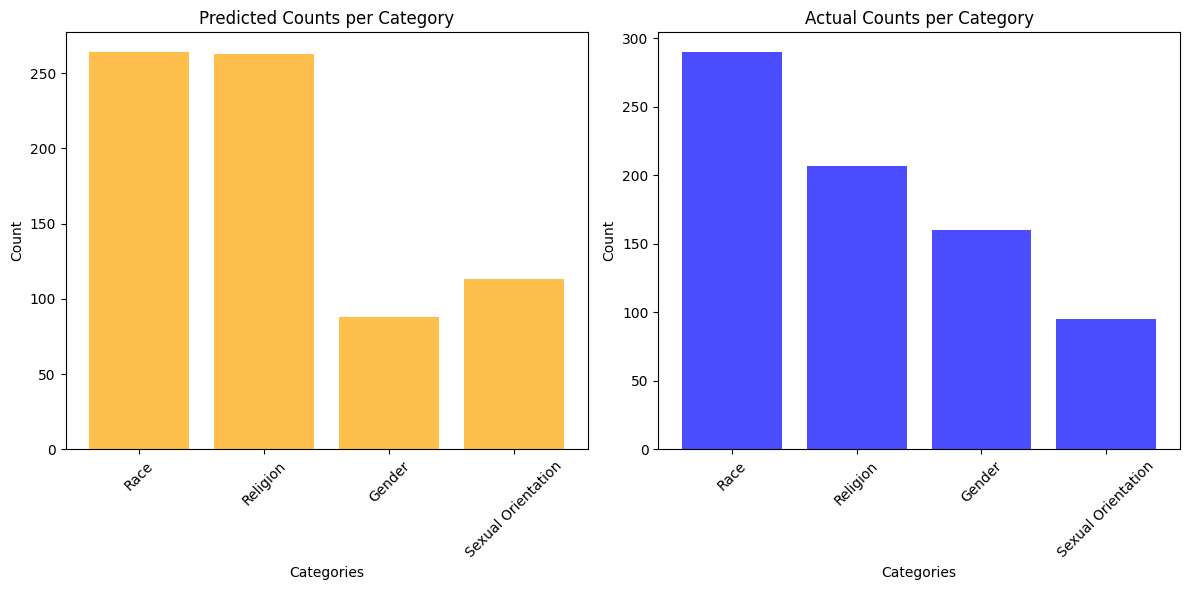

In [57]:
import matplotlib.pyplot as plt
import numpy as np


# Summing the counts for each category
predicted_counts = predictions.sum(axis=0)

label_counts = labels.sum(axis=0)
categories = ["Race","Religion","Gender","Sexual Orientation"]

# Plot predicted counts
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.bar(categories, predicted_counts, color='orange', alpha=0.7)
plt.title('Predicted Counts per Category')
plt.xlabel('Categories')
plt.ylabel('Count')
plt.xticks(rotation=45)

# Plot actual label counts
plt.subplot(1, 2, 2)
plt.bar(categories, label_counts, color='blue', alpha=0.7)
plt.title('Actual Counts per Category')
plt.xlabel('Categories')
plt.ylabel('Count')
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()


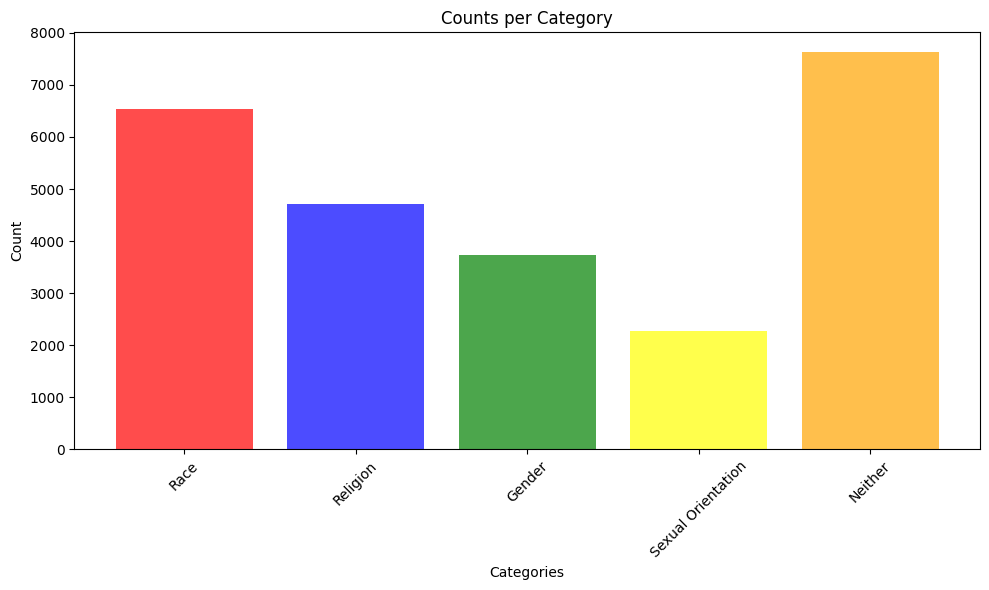

In [ ]:
import matplotlib.pyplot as plt

columns = ["Race", "Religion","Gender","Sexual Orientation"] 

true_counts = {col: df[col].sum() for col in columns}
    

none_true_count = (df[columns].sum(axis=1) == 0).sum()


categories = list(true_counts.keys()) + ['Neither']
counts = list(true_counts.values()) + [none_true_count]


plt.figure(figsize=(10, 6))
plt.bar(categories, counts, color=['red','blue','green','yellow','orange'], alpha=0.7)


plt.title('Counts per Category')
plt.xlabel('Categories')
plt.ylabel('Count')
plt.xticks(rotation=45)  

# Show the plot
plt.tight_layout()
plt.show()